# Notes

- This code includes visualisation of results in a graph and exports results to csv file
- To choose what to visualise, set that variable to True in ```plot_energy_flows```. For example, if you want to visualise the PV Energy Used, set ```view_pv_flow = True```. If you don't want to view_pv_flow, set ```view_pv_flow = False```.

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import random
from statistics import mean
import matplotlib.pyplot as plt
import copy
import math
import matplotlib.pyplot as plt

# Initial Parameters

In [2]:
start_date = '2022-01-03 00:00:00'
end_date = '2022-01-08 00:00:00'
batCap = 500  # in kWh
chargeRate = 250  # in kW
initial_soc = 0 # in kWh, the state of charge in the battery at the start of the time horizon
charge_discharge_percentage = random.uniform(0.5, 1)
# Define TOU rates for 24 hours (hour 0 = 0.23, hour 1 = 0.28, etc.)
tou_rates = {
    0: 0.23, 1: 0.28, 2: 0.27, 3: 0.25, 4: 0.22, 5: 0.20,   # 12 AM - 6 AM
    6: 0.30, 7: 0.35, 8: 0.40, 9: 0.45, 10: 0.42, 11: 0.38, # 6 AM - 12 PM
    12: 0.46, 13: 0.44, 14: 0.52, 15: 0.53, 16: 0.47, 17: 0.68, # 12 PM - 6 PM
    18: 0.64, 19: 0.50, 20: 0.45, 21: 0.35, 22: 0.29, 23: 0.22  # 6 PM - 12 AM
}
# Define whether to include PV energy or not
pv_energy = True

# Data Preprocessing

In [3]:
df_prediction = pd.read_csv('Vyskov.csv')
df_consumption = pd.read_csv('historie-spotreb-elektrina.csv')
column_renames = {"Datum a čas": "Timestamp",
                  "Činná spotřeba hodinová (kWh)": "Hourly consumption (kWh)",
                  "Jalová spotřeba při spotřebě hodinová (kVAR)": "Reactive hourly consumption (kVAR)",
                  "Jalová dodávka při spotřebě hodinová (kVAR)": "Reactive supply hourly consumption (kVAR)"
                  }
df_consumption = df_consumption.rename(columns=column_renames)

prediction_column_rename = {"time_utc": "Timestamp", "production_prediction": "PV Energy Prediction (kWh)"}

df_prediction = df_prediction.rename(columns = prediction_column_rename)

df_consumption['Timestamp'] = pd.to_datetime(df_consumption['Timestamp'], format='%d.%m.%Y %H:%M')
df_prediction['Timestamp'] = pd.to_datetime(df_prediction['Timestamp'], format='%d/%m/%Y %H:%M')

df_consumption = df_consumption[["Timestamp", "Hourly consumption (kWh)"]]
df_prediction = df_prediction[["Timestamp", "PV Energy Prediction (kWh)"]]

df_combined = pd.merge(df_consumption, df_prediction, on="Timestamp")
df_combined.set_index('Timestamp', inplace=True)

# Function to slice the DataFrame based on the start and end date
def get_time_horizon(df, start_date, end_date):
    # Ensure start_date and end_date are datetime objects
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Slice the DataFrame using the loc function
    sliced_df = df.loc[start_date:end_date].copy()
    
    return sliced_df

# Get the sliced DataFrame for the defined time horizon
df = get_time_horizon(df_combined, start_date, end_date)

# Extract the hour and assign TOU rates using .loc to avoid the SettingWithCopyWarning
df.loc[:, 'hour'] = df.index.hour
df.loc[:, 'TOU (€/kWh)'] = df['hour'].map(tou_rates)

# Drop the 'hour' column as it's no longer needed
df.drop(columns=['hour'], inplace=True)
# Reset the index
df = df.sort_values(by='Timestamp')
'''
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
df = pd.concat([df,df], axis=0)
'''
df = df.reset_index()
df = df.reset_index(names='row_num')
# df = df[:5]

# Making all PV energy generation 0
if not pv_energy:
    df['PV Energy Prediction (kWh)'] = 0

df

,row_num,Timestamp,Hourly consumption (kWh),PV Energy Prediction (kWh),TOU (€/kWh)
0,0,2022-01-03 00:00:00,21,0.000607,0.23
1,1,2022-01-03 01:00:00,22,0.000607,0.28
2,2,2022-01-03 02:00:00,22,0.000607,0.27
3,3,2022-01-03 03:00:00,21,0.000607,0.25
4,4,2022-01-03 04:00:00,22,0.000607,0.22
...,...,...,...,...,...
116,116,2022-01-07 20:00:00,246,0.000607,0.45
117,117,2022-01-07 21:00:00,234,0.000607,0.35
118,118,2022-01-07 22:00:00,235,0.000607,0.29
119,119,2022-01-07 23:00:00,224,0.000607,0.22


# LP Model

In [4]:
TOU = np.array(df['TOU (€/kWh)']) #np.array([0.23, 0.28, 0.27, 0.25, 0.22])
PV_pred = np.array(df['PV Energy Prediction (kWh)'])
consumption = np.array(df['Hourly consumption (kWh)'])
timestamp = np.array(df['Timestamp'])

numNodes= len(df)
lastNode = numNodes-1
LB = gp.Model("LB")
LB.setParam('OutputFlag', 0) 
# print("c_LB ", c_LB)
# print("c_UB ", c_UB)
# Add decision variables

#Flow from grid
x_grid = LB.addVars([i for i in range(numNodes)], vtype=GRB.CONTINUOUS, name="x_grid")

#Flow from PV
x_PV = LB.addVars([i for i in range(numNodes)], vtype=GRB.CONTINUOUS, name="x_PV")

#Flow from battery
x_Flow = LB.addVars([i for i in range(numNodes)],  vtype=GRB.CONTINUOUS, name="x_Flow")


#Source 0
constr1 = x_Flow[0] == 0 #Assuming battery storage starts at 0
LB.addConstr(constr1)
constr1 = x_grid[0]+x_PV[0]+x_Flow[0]-x_Flow[0+1] - consumption[0] == 0 #Flow balance constraint 
LB.addConstr(constr1)


#Sink n
constr1 = x_grid[lastNode]+x_PV[lastNode]+x_Flow[lastNode] - consumption[lastNode] == 0 #Flow balance constraint 
LB.addConstr(constr1)


for i in range(1, numNodes-1):
    # if i == 0:
    #     constr1 = sum(x_grid[i]+x_PV[i]+x_Flow[i] - x_Flow[i+1]) == 0
    # if i == numNodes:
    #     constr1 = x_grid[i]+x_PV[i]+x_Flow[i] - consumption[i] == 0 
    #     LB.addConstr(constr1)
    # else:
    constr1 = x_grid[i]+x_PV[i]+x_Flow[i] - x_Flow[i+1] - consumption[i] == 0 #Flow balance constraint 
    LB.addConstr(constr1)
    
for i in range(numNodes):       
    constr1 = x_PV[i] <= PV_pred[i] #Can't take more PV than what's generated 
    LB.addConstr(constr1)
    constr1 = x_Flow[i] <= batCap #Can't store more than capacity of battery
    LB.addConstr(constr1)

for i in range(numNodes-1): #Don't need this constraint for the last hour since we shouldn't be charging
    constr1 = x_Flow[i+1] - x_Flow[i] <= chargeRate #Flow balance charge constraint 
    LB.addConstr(constr1)
    constr1 = x_Flow[i+1] - x_Flow[i] >= -chargeRate #Flow balance discharge constraint 
    LB.addConstr(constr1)
    
LB.addConstr(constr1)

LB.setObjective(sum(TOU[i]*x_grid[i] for i in range(numNodes)), sense=GRB.MINIMIZE) #Minimize electricity cost


LB.optimize()
    
#     print(PSP)
#     PSP.write("M2.mps")
#print(PSP.display())
# Print the results
if LB.status == GRB.OPTIMAL:
    print("Optimal solution found:")
    print(f"Objective value = {LB.objVal}")
    totalCost =LB.objVal
else:
    print("No optimal solution found.")

x_Flow_sol = np.zeros(numNodes)
x_grid_sol = np.zeros(numNodes)
x_PV_sol = np.zeros(numNodes)
x_bat_change_sol = np.zeros(numNodes)
if LB.status == GRB.OPTIMAL:
    for k in range(numNodes):
        x_Flow_sol[k] = x_Flow[k].x
        x_grid_sol[k] = x_grid[k].x
        x_PV_sol[k] = x_PV[k].x
    for k in range(numNodes - 1):
        x_bat_change_sol[k] = x_Flow[k+1].x - x_Flow[k].x

print("x_Flow ", x_Flow_sol)
print("x_grid ", x_grid_sol)
print("x_PV ", x_PV_sol)
# q = LB.addVars([a for a in range(numArcs)], vtype=GRB.CONTINUOUS, name="q")
# d = LB.addVars([a for a in range(numArcs)], vtype=GRB.CONTINUOUS, name="d")
#     print("numCells ", numCells)
#     print("range(numCells) ", range(numCells))
#     print("range(numArcs) ", range(numArcs))
# lamb = LB.addVars([k for k in range(numCells)], vtype=GRB.CONTINUOUS, name="lamb")
# nu = LB.addVars([k for k in range(numCells)], vtype=GRB.BINARY, name="nu")
# z = LB.addVar(vtype=GRB.CONTINUOUS, name="z")

# # print(y)
# # print("delta ", delta)
# # Set objective function

# #     PSP.update()
# #     print()
# for a in DP:
#     # print(y[(k,Head[a])])
#     constr1 = y[Tail[a]] - y[Head[a]] == c_LB[a] - dVals[a] + M[a]*q[a]
#     LB.addConstr(constr1)
#     LB.update()

df10 = pd.DataFrame({
    'x_Flow': x_Flow_sol,
    'x_grid': x_grid_sol,
    'x_PV': x_PV_sol,
    'x_bat_change': x_bat_change_sol,
    'TOU': TOU,
    'PV_pred':PV_pred,
    'consumption':consumption,
    'Timestamp':timestamp
    
})

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-18
Optimal solution found:
Objective value = 11225.741320044359
x_Flow  [  0.          64.99817962  42.99878641  20.99939321   0.
 250.         500.         500.         500.         500.
 276.219275   250.         500.         331.49937515 500.
 482.98950259 232.98950259 482.98950259 232.98950259   0.
   0.           0.           0.           0.         250.
 258.99817962 136.99878641  54.99939321   0.         250.
 500.         500.         500.         500.         250.
 250.         500.         250.         500.         500.
 250.         500.         250.           0.           0.
   0.           0.           0.         250.         262.99817962
 146.99878641  68.99939321   0.         250.         500.
 500.         500.         500.         250.         250.
 500.         291.45946482 500.         500.         250.
 500.         250.           0.           0.           0.
   0.           0.  

In [5]:
df10

,x_Flow,x_grid,x_PV,x_bat_change,TOU,PV_pred,consumption,Timestamp
0,0.000000,85.997573,0.000607,64.998180,0.23,0.000607,21,2022-01-03 00:00:00
1,64.998180,0.000000,0.000607,-21.999393,0.28,0.000607,22,2022-01-03 01:00:00
2,42.998786,0.000000,0.000607,-21.999393,0.27,0.000607,22,2022-01-03 02:00:00
3,20.999393,0.000000,0.000607,-20.999393,0.25,0.000607,21,2022-01-03 03:00:00
4,0.000000,271.999393,0.000607,250.000000,0.22,0.000607,22,2022-01-03 04:00:00
...,...,...,...,...,...,...,...,...
116,0.000000,245.999393,0.000607,0.000000,0.45,0.000607,246,2022-01-07 20:00:00
117,0.000000,233.999393,0.000607,0.000000,0.35,0.000607,234,2022-01-07 21:00:00
118,0.000000,234.999393,0.000607,0.000000,0.29,0.000607,235,2022-01-07 22:00:00
119,0.000000,438.998786,0.000607,214.999393,0.22,0.000607,224,2022-01-07 23:00:00


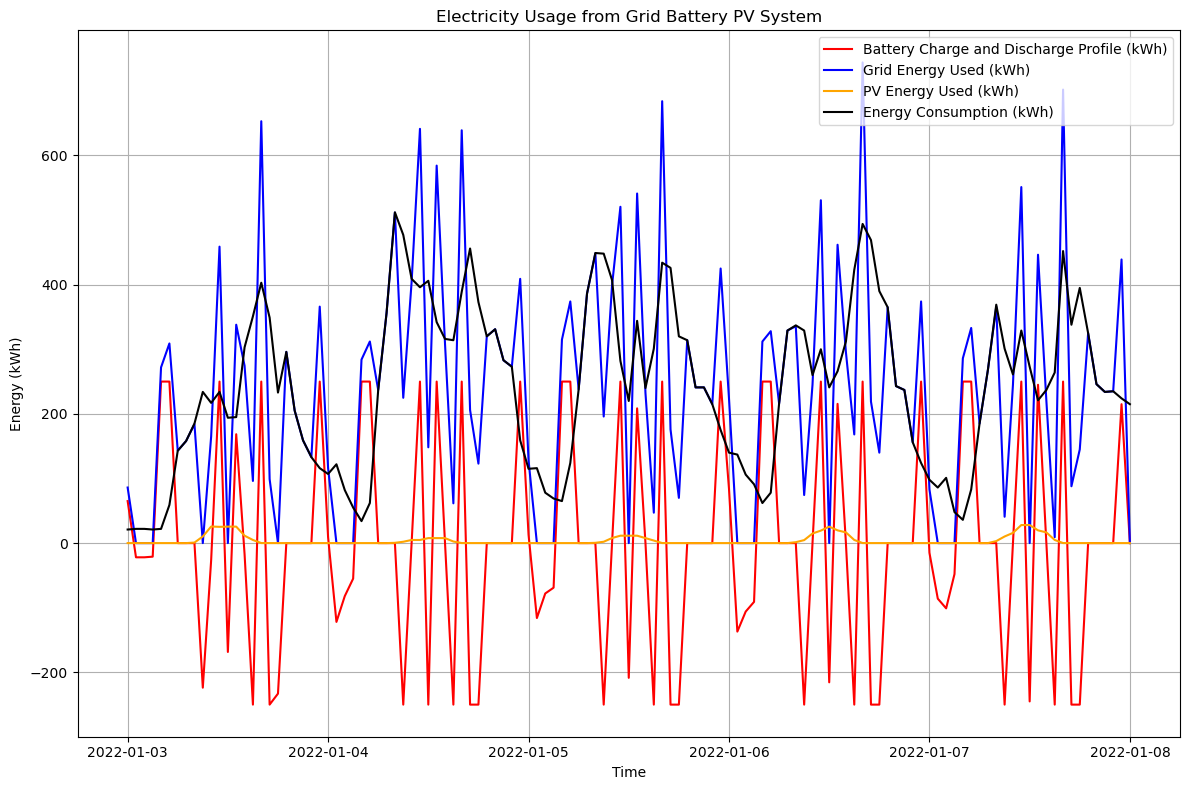

In [6]:
def plot_energy_flows(df, initial_soc):
    """
    Plot the energy flows (PV used, grid energy used, consumption) and battery state over time.

    Parameters:
    df (pd.DataFrame): The dataframe containing the energy flows and consumption data.
    initial_soc (float): The initial state of charge of the battery (kWh). Defined in Parameters Section

    Columns expected in df:
    - 'x_PV': PV energy used (kWh)
    - 'x_grid': Grid energy used (kWh)
    - 'consumption': Total energy consumption (kWh)
    - 'x_bat_change': Battery change (kWh)
    """
    # Define the PV energy flow of energy
    pv_flow = df['x_PV']
    # Define the grid flow of energy
    grid_flow = df['x_grid']
    # Define the battery charging and discharging profile
    battery_charge_discharge_profile = df['x_bat_change']
    # Calculate battery state over time (cumulative sum of battery flow changes)
    battery_state = df['x_bat_change'].cumsum() + initial_soc  # State of Charge (SOC)
    # Define the Energy Consumption
    consumption = df['consumption']
    # Define the time horizon
    timestamps = df['Timestamp']
    
    view_pv_flow = True
    view_grid_flow = True
    view_battery_charge_discharge_profile = True
    view_battery_state = False
    view_consumption = True

    # Create a new figure for the plot
    plt.figure(figsize=(12, 8))
    
    # Plot battery charge and discharge rate
    # Positive values are battery charging, negative values are battery discharging
    if view_battery_charge_discharge_profile:
        plt.plot(timestamps, df['x_bat_change'], label='Battery Charge and Discharge Profile (kWh)', color='red')
    

    # Plot grid energy used
    if view_grid_flow:
        plot_title_grid = 'Grid'
        plt.plot(timestamps, df['x_grid'], label='Grid Energy Used (kWh)', color='blue')
    else:
        plot_title_grid = ''
    
    # Plot PV energy used
    if view_pv_flow:
        plot_title_pv = 'PV System'
        plt.plot(timestamps, df['x_PV'], label='PV Energy Used (kWh)', color='orange')
    else:
        plot_title_pv = ''


    # Plot battery state
    if view_battery_state:
        plt.plot(timestamps, battery_state, label='Battery State of Charge (kWh)', color='green')
    
    if view_battery_state or view_battery_charge_discharge_profile:
        plot_title_bat = 'Battery'
    else:
        plot_title_bat = ''
    
    # Plot total consumption
    if view_consumption:
        plt.plot(timestamps, df['consumption'], label='Energy Consumption (kWh)', color='black')

    # Set the title and labels
    plt.title(f'Electricity Usage from {plot_title_grid} {plot_title_bat} {plot_title_pv}')
    plt.xlabel('Time')
    plt.ylabel('Energy (kWh)')

    # Add a legend to the plot
    plt.legend(loc='upper right')

    # Show the plot
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# Usage Example:
plot_energy_flows(df10, initial_soc=initial_soc)


In [7]:
start_date_split = start_date.split()
start_date_only = start_date_split[0]

end_date_split = end_date.split()
end_date_only = end_date_split[0]

In [8]:
if pv_energy == True:
    pv_status = 'WITH_PV'
else:
    pv_status = 'NO_PV'

In [9]:
df10.to_csv(f"LP_SPOT_TOU_{pv_status}_{start_date_only}_{end_date_only}_PV_{batCap}kWh_{chargeRate}kWh.csv")